In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [133]:
N = 1000
p = 300
T = 120
idiovol_sigma = np.sqrt(0.3*0.3/12)
e_mu = np.sqrt(0.2*0.2/12)
e_sigma = e_mu
mu = 0.1/12/e_mu
w0 = np.zeros(N) # for now
returns = []

gamma = 1
c = 1
a = 1.5
b = 1.5
# values_new = []

values_new = []

# X
factors = []
# y
y = []

lambdas = np.geomspace(1,1500,30)
utility_avg = []

# Save different samples through different simulations


for s in range(100): # can change the simulation number
    beta = np.zeros((N,p)) 
    beta[:,0] = e_mu
    mus = np.zeros((N,p))
    mus[:,0] = mu
    returns = []
    fs = []
    for j in range(1,p):
        beta[:,j-1] = e_mu*j**(-a)  # draw an N*p matrix of beta
        mus[:,j-1] = mu*j**(-b)  # draw an N*p matrix of mus
        alpha = (beta * mus).sum(axis = 1) # get the factor risk premia
        #     beta_hat_stocks = [] # to store the betas for each stock after their ridge regression
        #     alpha_hat_stocks = [] # to store the alphas for each stock after their ridge regression
        #     sigma_ridge = []
    for stock in range(N):
        f = np.random.multivariate_normal(np.zeros(p), np.identity(p), T) # for each stock generate the factor matrix
        epsilon = np.random.normal(0,idiovol_sigma,T) #generate the residuals
        r = alpha[stock] + np.array(beta[stock]).T @ f.T + epsilon # calculate the return series for each stock
        returns.append(r.T)
        fs.append(f)

    y.append(returns) 
    factors.append(fs)
            

In [3]:
lambdas = np.geomspace(1,1500,30)


utility_avg = []

for l in lambdas:
    value_l = []
    for s in range(np.shape(y)[0]):
        beta_hat_stocks = []
        alpha_hat_stocks = []
        sigma_ridge = []
        for stock in range(N):
        #             ridge_betas = ridge_closed(factors[s][stock], y[s][stock], l)[0]
        #             ridge_intercept = ridge_closed(factors[s][stock], y[s][stock], l)[1]
            ridge = Ridge(alpha = l, fit_intercept = True).fit(factors[s][stock], y[s][stock])

            beta_hat_stocks.append(ridge.coef_)
            alpha_hat_stocks.append(ridge.intercept_)
            sigma_ridge.append(np.var(y[s][stock] - ridge.intercept_ - ridge.coef_ @ factors[s][stock].T))
        sigma_hat = np.array(beta_hat_stocks) @ np.array(beta_hat_stocks).T + sigma_ridge @ np.identity(N)
        weights = np.linalg.inv(gamma * sigma_hat + c * np.identity(N)) @ (alpha_hat_stocks + c * w0)
        sigma_true = beta @ beta.T + np.identity(N)*idiovol_sigma**2 
        value = weights.T @ alpha - 0.5*gamma*weights.T @ sigma_true @ weights - 0.5*c*np.sqrt(sum((weights - w0)**2))
        value_l.append(value)
    utility_avg.append(np.mean(value_l))

## Statistical $\lambda$

In [47]:
def lambda_value(l):
    value_statsl = []
    for s in range(np.shape(y)[0]):
        beta_hat = []
        alpha_hat = []
        sigma_ridge = []
        for stock in range(N):
            ridge = Ridge(alpha = l, fit_intercept = True).fit(factors[s][stock], y[s][stock])
            beta_hat.append(ridge.coef_)
            alpha_hat.append(ridge.intercept_)
            sigma_ridge.append(np.var(y[s][stock] - ridge.intercept_ - ridge.coef_ @ factors[s][stock].T))
        sigma_hat = np.array(beta_hat) @ np.array(beta_hat).T + sigma_ridge @ np.identity(N)
        weights = np.linalg.inv(gamma * sigma_hat + c * np.identity(N)) @ (alpha_hat_stocks + c*w0)
        sigma_true = beta @ beta.T + np.identity(N)*idiovol_sigma**2
        value = weights.T @ alpha - 0.5*gamma*weights.T @ sigma_true @ weights - 0.5 * c*np.sqrt(sum((weights-w0)**2))
        value_statsl.append(value)
    return np.mean(value_statsl)

In [48]:
stats_lambda = (N*(p+1)*idiovol_sigma**2)/((sum(alpha**2)+sum(sum(beta**2)))*T)
stats_utility = lambda_value(stats_lambda)

Text(0.5, 1.0, 'when gamma = 1, c = 1(normal a, b)')

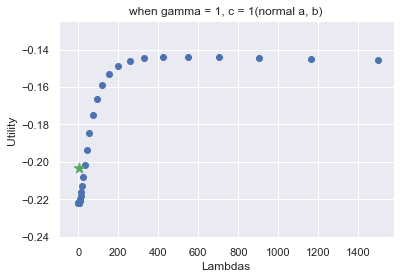

In [49]:
plt.scatter(y = utility_avg, x = lambdas)
plt.scatter(y = stats_utility, x = stats_lambda, marker='*',s=120, c='g')
plt.ylabel('Utility')
plt.xlabel('Lambdas')
plt.title('when gamma = 1, c = 1(normal a, b)')

## Economic $\lambda$

In [74]:
mu_f = mus[0]
sigma_bar = gamma * sigma_true + c*np.identity(N)
sigma_bar_v = np.linalg.inv(sigma_bar)
B1 = sigma_bar_v.trace()
M = beta @ mu_f + c*w0

B2 = B1*M.T @ sigma_bar_v @ beta @ beta.T @ sigma_bar_v @ M
beta_b_beta = beta.T @ sigma_bar_v @ beta
B3 = gamma**2 * beta_b_beta.trace()*M.T @ sigma_bar_v @ sigma_bar_v @ M
B4 = 2*gamma**2 * M.T @ sigma_bar_v @ sigma_bar_v @ beta @ beta.T @ sigma_bar_v @ M

M_f = beta @ mu_f + 2*gamma*beta@beta.T @sigma_bar_v@M

denominator = M_f.T @ sigma_bar_v @ M_f

eml = ((idiovol_sigma**2)/T)*((B1+B2+B3+B4)/denominator)
eml

0.46621080213830335

In [76]:
eml_utility = lambda_value(eml)

Text(0.5, 1.0, 'when gamma = 1, c = 1(normal a, b)')

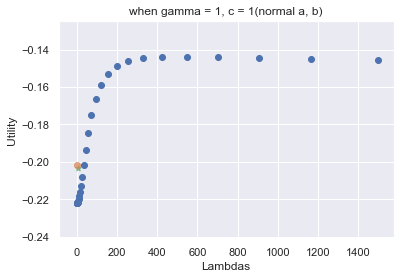

In [84]:
plt.scatter(y = utility_avg, x = lambdas)
plt.scatter(y = stats_utility, x = stats_lambda, marker='*', c='g', alpha = 0.7)
plt.scatter(y = eml_utility, x = eml, marker = 'o', alpha = 0.7)
plt.ylabel('Utility')
plt.xlabel('Lambdas')
plt.title('when gamma = 1, c = 1(normal a, b)')

In [134]:
lambdas = np.geomspace(1,1000,30)


utility_avg = []

for l in lambdas:
    value_l = []
    for s in range(np.shape(y)[0]):
        beta_hat_stocks = []
        alpha_hat_stocks = []
        sigma_ridge = []
        for stock in range(N):
        #             ridge_betas = ridge_closed(factors[s][stock], y[s][stock], l)[0]
        #             ridge_intercept = ridge_closed(factors[s][stock], y[s][stock], l)[1]
            ridge = Ridge(alpha = l, fit_intercept = True).fit(factors[s][stock], y[s][stock])

            beta_hat_stocks.append(ridge.coef_)
            alpha_hat_stocks.append(ridge.intercept_)
            sigma_ridge.append(np.var(y[s][stock] - ridge.intercept_ - ridge.coef_ @ factors[s][stock].T))
        sigma_hat = np.array(beta_hat_stocks) @ np.array(beta_hat_stocks).T + sigma_ridge @ np.identity(N)
        weights = np.linalg.inv(gamma * sigma_hat + c * np.identity(N)) @ (alpha_hat_stocks + c * w0)
        sigma_true = beta @ beta.T + np.identity(N)*idiovol_sigma**2 
        value = weights.T @ alpha - 0.5*gamma*weights.T @ sigma_true @ weights - 0.5*c*np.sqrt(sum((weights - w0)**2))
        value_l.append(value)
    utility_avg.append(np.mean(value_l))

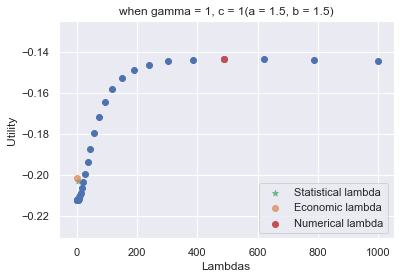

In [138]:
plt.scatter(y = utility_avg, x = lambdas)
plt.scatter(y = stats_utility, x = stats_lambda, marker='*', c='g', alpha = 0.7,label = 'Statistical lambda')
plt.scatter(y = eml_utility, x = eml, marker = 'o', alpha = 0.7,label = 'Economic lambda')
plt.scatter(y = max(utility_avg), x = lambdas[np.argmax(utility_avg)], c = 'r', label = 'Numerical lambda')
plt.ylabel('Utility')
plt.xlabel('Lambdas')
plt.title('when gamma = 1, c = 1(a = 1.5, b = 1.5)')
plt.legend()

In [137]:
b

1.5

In [110]:
lambdas

array([   1.        ,    1.268961  ,    1.61026203,    2.04335972,
          2.5929438 ,    3.29034456,    4.17531894,    5.29831691,
          6.72335754,    8.53167852,   10.82636734,   13.73823796,
         17.43328822,   22.12216291,   28.07216204,   35.6224789 ,
         45.20353656,   57.3615251 ,   72.78953844,   92.36708572,
        117.21022975,  148.73521073,  188.73918221,  239.502662  ,
        303.91953823,  385.66204212,  489.39009185,  621.01694189,
        788.04628157, 1000.        ])